# Part I. One-sided finite differences

Write a function, `deriv`, which computes a derivative of its argument at a given point, $x$, using a one-sided finite difference rule with a given step side $h$, with the approximation order of $O(h^2)$. 

In [1]:
def deriv(f, x, h):
    """ Compute a derivative of `f` at point `x` with step size `h`.
    
    Compute the derivative using the one-sided rule of the approximation order of $O(h^2)$.
    
    Parameters
    ----------
    f : callable
        The function to differentiate
    x : float
        The point to compute the derivative at.
    h : float
        The step size for the finite different rule.
        
    Returns
    -------
    fder : derivative of f(x) at point x using the step size h.
    """
    return (-1.5 * f(x) + 2 * f(x + h) - 0.5 * f(x + 2 * h)) / h

#### Test I.1

Test your function on a simple test case: differentiate $f(x) = x^3$ at $x=0$. Comment on whether your results are consistent with the expected value of $f'(x) = 0$ and on an expected scaling with $h\to 0$.

 (10% of the total grade)

In [2]:
x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(lambda x: x**3, x, h)
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.0002
0.001000 --  -2e-06
0.000100 --  -2e-08
0.000010 --  -2e-10


Видим, что точность вычисления производной действительно равна $O(h^2)$: при уменьшении $h$ на один порядок точность увеличивается на два порядка

### Test I.2

Now use a slightly more complicated function, $f(x) = x^2 \log{x}$, evaluate the derivative at $x=1$ using your one-sided rule and a two-point one-sided rule. Roughly estimate the value of $h$ where the error stops decreasing, for these two schemes. 
(15% of the total grade)

In [3]:
from math import log

def f(x):
    return x**2 * log(x)
    
def fder(x):
    return x * (2.*log(x) + 1)

Сначала напишем функцию для нахождения производной с двухточечной схемой

In [4]:
def deriv_1(f, x, h):
    return (f(x + h) - f(x)) / h

In [5]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [6]:
x = 1
der_true = fder(x)
h = 1 / 10**(np.arange(8, 64) / 4)

Найдём $h_{opt}$ для двухточечной схемы:

In [7]:
err1 = np.array([])
for i in h:
    err1 = np.append(err1, abs(deriv_1(f, x, i) - der_true))
print('Минимальная ошибка при h = {}'.format(*h[np.where(err1 == min(err1))]))

Минимальная ошибка при h = 1e-08


И для трёхточечной схемы:

In [8]:
err2 = np.array([])
for i in h:
    err2 = np.append(err2, abs(deriv(f, x, i) - der_true))
print('Минимальная ошибка при h = {}'.format(*h[np.where(err2 == min(err2))]))

Минимальная ошибка при h = 3.1622776601683796e-06


<IPython.core.display.Javascript object>


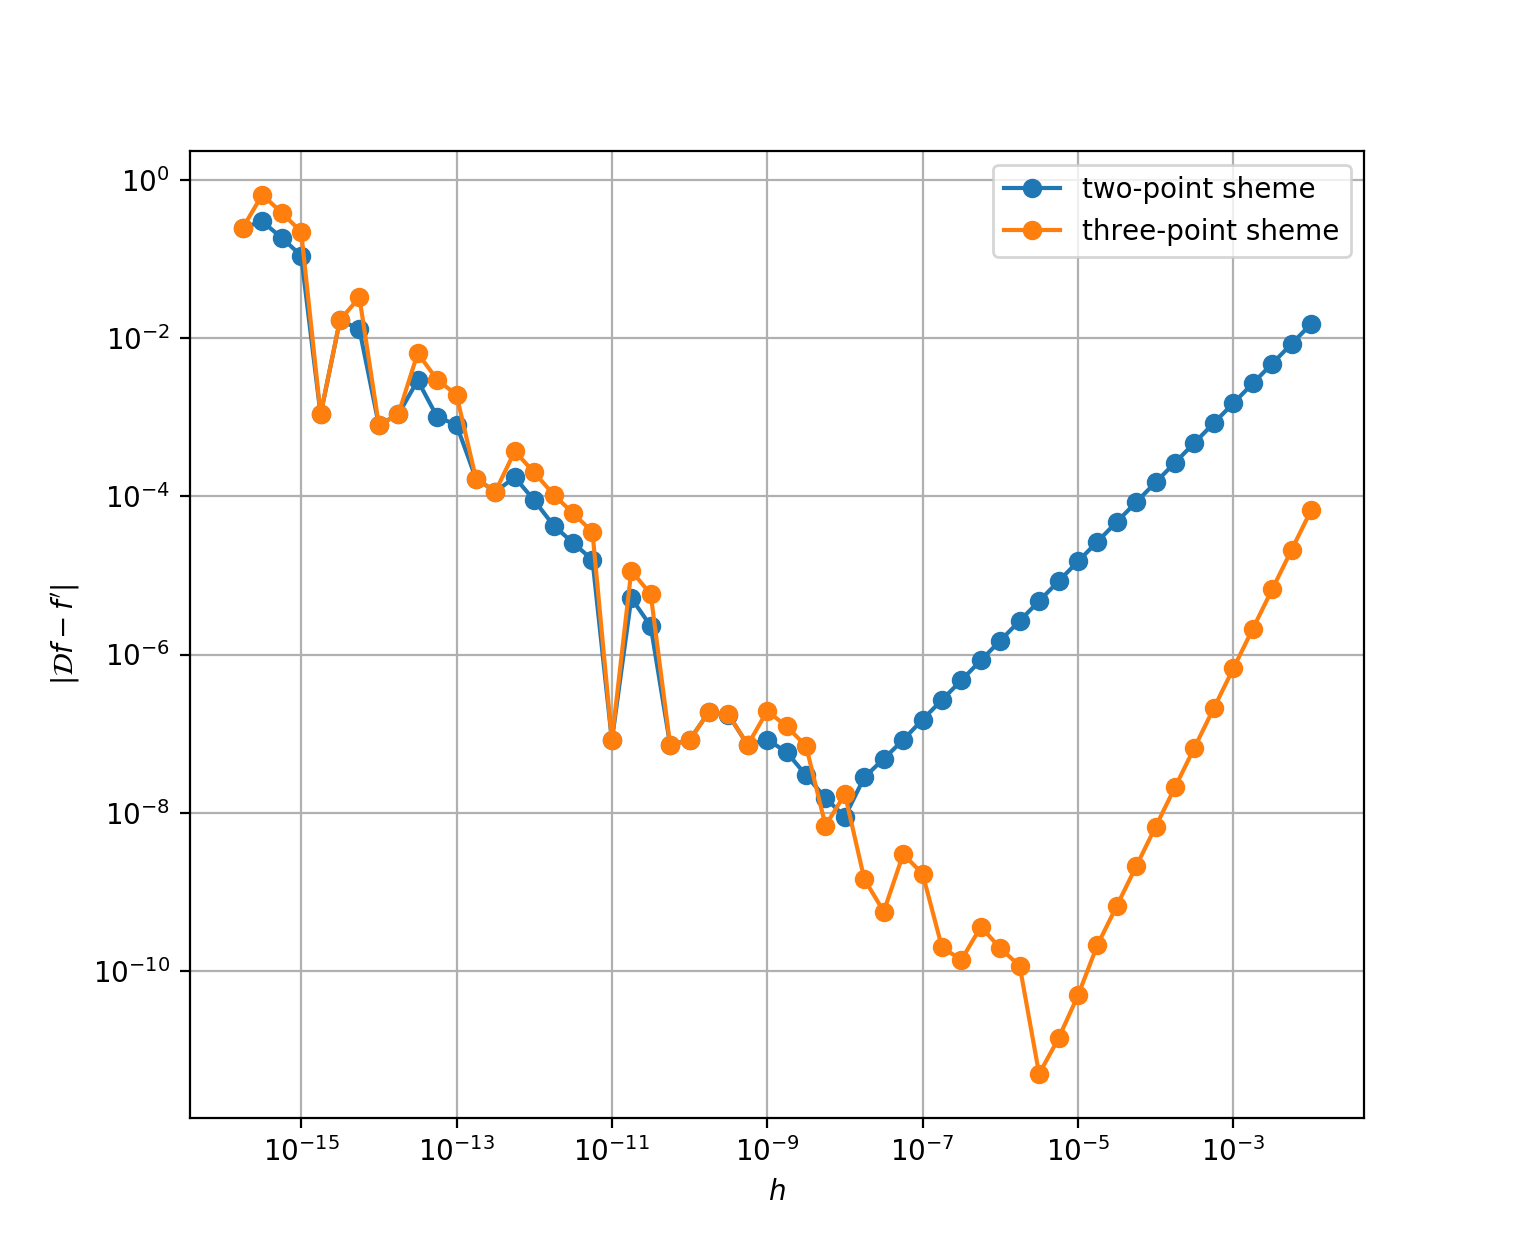

In [9]:
plt.figure()
plt.plot(h, err1, 'o-', label='two-point sheme')
plt.plot(h, err2, 'o-', label='three-point sheme')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('$h$')
plt.ylabel("$\|\mathcal{D}f-f'\|$")
plt.legend()

### Test I.3 

Now try differentiating $x^2 \log(x)$ at $x=0$. Use the three-point one-sided rule. Note that to evaluate the function at zero, you need to special-case this value. Check the scaling of the error with $h$, explain your results. 
(25% of the total grade)

In [10]:
def f(x):
    if x == 0:
        # the limit of $x^2 log(x)$ at $x-> 0$ is zero, even though log(x) is undefined at x=0
        return 0.0
    else:
        return x**2 * log(x)
    
def fder(x):
    if x == 0:
        return 0.0
    else:
        return x*(2*log(x) + 1)

x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(f, x, h) - fder(x)
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.01386
0.001000 -- -0.001386
0.000100 -- -0.0001386
0.000010 -- -1.386e-05


Вспомним, как выглядит схема вычисления производной:
$$
f'(0) \approx \frac{-1.5f(0) + 2f(h) - 0.5f(2h)}{h}
$$

Теперь посчитаем производные нашей функции:
$$f = x^2\log(x) \Rightarrow f'=x\Big(\log(x^2)+1\Big) \Rightarrow f'' = \log(x^2)+3 \Rightarrow f''' = \frac{2}{x}$$





Сразу можно сказать, что, так как предел первой производной в нуле равен нулю, при подстановке в нашу схему остаётся:
$$\frac{\frac{2 f'''(0)}{6}h^3 - \frac{0.5f'''(0)}{6}8h^3 +O(h^4)}{h} = - \frac{f'''(0)}{3}h^2 +O(h^3)$$
Да простит меня наш лектор по мат.анализу, но так как у нас есть проблемы с определением третьей производной в нуле, возьмём вместо неё предел $f'''(h)$ при $h \to 0$. Тогда можно сказать, что наша первая производная равна $-\frac{2}{3h}h^2 + O(h^3) = -\frac{2}{3}h + O(h^3) = O(h)$. То есть получили, что для этой функции в нуле даже трёхточечная схема даёт линейный характер сходимости, что совпадает с результатами проверки

# Part II. Midpoint rule 

Write a function which computes a definite integral using the midpoint rule up to a given error, $\epsilon$. Estimate the error by comparing the estimates of the integral at $N$ and $2N$ elementary intervals. 

In [11]:
def midpoint_rule(func, a, b, eps):
    """ Calculate the integral of f from a to b using the midpoint rule.
    
    Parameters
    ----------
    func : callable
        The function to integrate.
    a : float
        The lower limit of integration.
    b : float
        The upper limit of integration.
    eps : float
        The target accuracy of the estimate.
        
    Returns
    -------
    integral : float
        The estimate of $\int_a^b f(x) dx$.
    """
    I1 = (b - a) * func((b + a) / 2)
    I2 = (b - a) / 2 * (func(0.25 * b + 0.75 * a) + func(0.25 * a + 0.75 * b))
    n = 2
    while abs((I2 - I1) / I1) > eps:
        n *= 2
        x = np.linspace(a, b, n+1)
        I1 = I2
        # Будем считать, что на вход подаются только функции, которые 
        # могут принимать в качестве аргумента массив 
        I2 = (b - a) / n * sum(func((x[1:] + x[:n]) / 2)) 
    return I2, n

### Test II.1

Test your midpoint rule on a simple integral, which you can calculate by paper and pencil.

Compare the rate of convergence to the expected $O(N^{-2})$ scaling by studying the number of intervals required for a given accuracy $\epsilon$.

Compare the numerical results to the value you calculated by hand. Does the deviation agree with your estimate of the numerical error?
(20% of the total grade)


Рассмотрим в качестве примера следующий интеграл:
$$\int_{0}^{20}\Big(\frac{\sin(x)}{x} - \mathrm{e}^{-x}\Big)\mathrm{d}x \approx 0.54824170310459...$$
Сначала убедимся, что написанная функция считает интеграл правильно:

In [12]:
f1 = lambda x: np.sin(x) / x - np.exp(-x)
I, _ = midpoint_rule(f1, 0, 20, 1e-9)
print(I)

0.5482417031640919


<IPython.core.display.Javascript object>


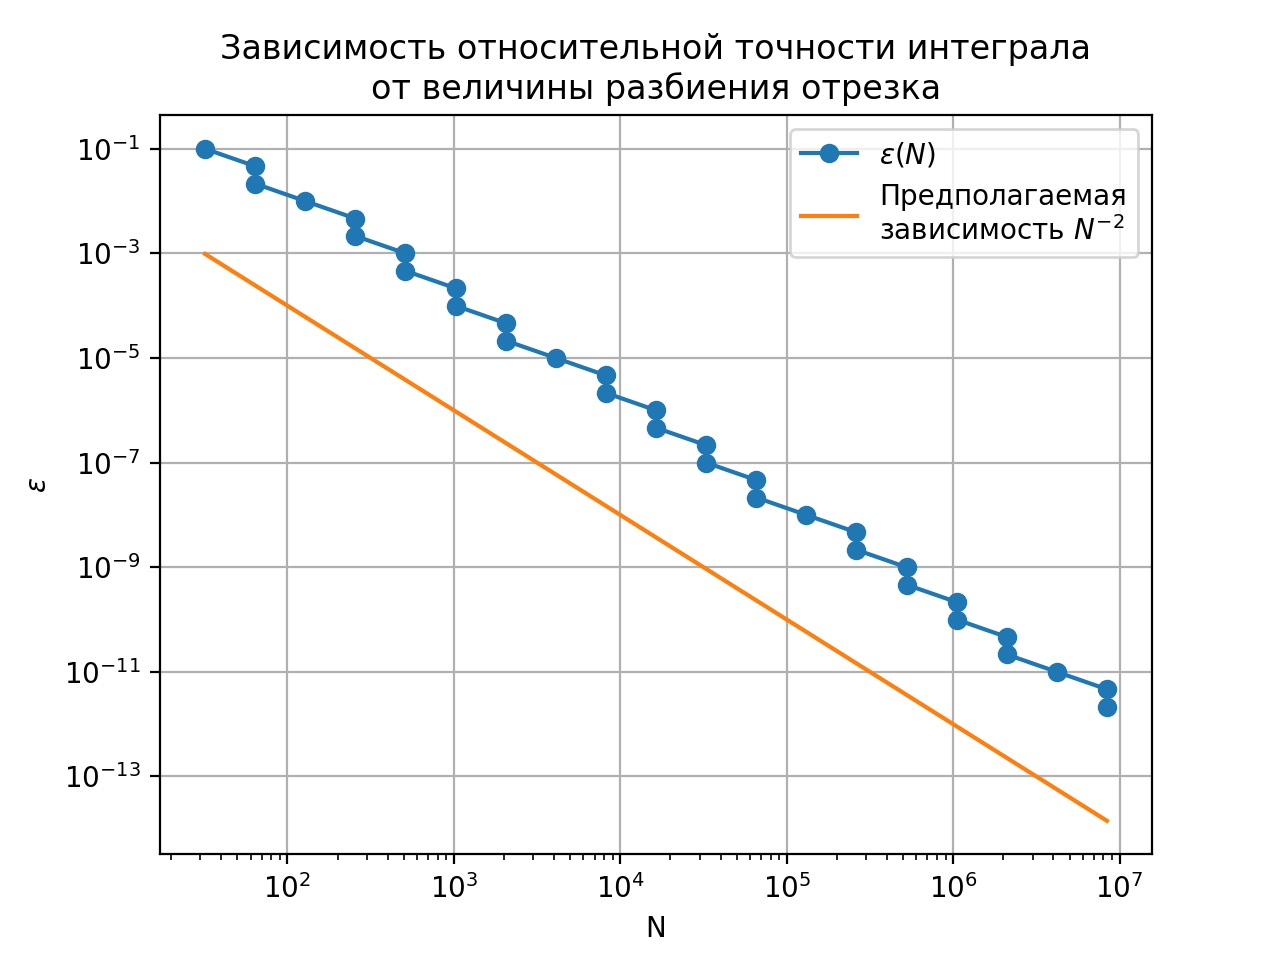

In [13]:
eps = 1 / 10**(np.arange(3, 36) / 3)
N = np.array([])
for i in eps:
    _, n = midpoint_rule(f1, 0, 20, i)
    N = np.append(N, n)

    
plt.figure()
plt.plot(N, eps, 'o-', label='$\epsilon(N)$')
plt.plot(N, 1 / N**2, label='Предполагаемая\nзависимость $N^{-2}$')
plt.title('Зависимость относительной точности интеграла\nот величины разбиения отрезка')
plt.xlabel('N')
plt.ylabel('$\epsilon$')  # не знаю, почему юпитер воспринимает запись как \varepsilon
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid()

Видно, что в логарифмических координатах фактическая зависимость параллельна теоретической: $$\log(\epsilon)=\log(N^{-2})+\log C=\log(C \cdot N^{-2}) \Rightarrow \epsilon = C \cdot N^{-2}$$
Следовательно, получилось подтвердить теоретическую зависимость

### Test II.2

Now use your midpoint rule to compute the value of

$$
\int_0^1\! \frac{\sin{\sqrt{x}}}{x}\, dx
$$

up to a predefined accuracy of $\epsilon=10^{-4}$.

Note that the integral contains an integrable singularity at the lower limit. Do calculations two ways: first, do a straightforward computation; next, subtract the singularity. Compare the number of iterations required to achieve the accuracy of $\epsilon$.

(30% of the total grade)

In [14]:
I, n = midpoint_rule(lambda x: np.sin(x**0.5) / x, 0, 1, 1e-4)
print('Значение интеграла: {}\nКоличество разбиений: {}'.format(I, n))

Значение интеграла: 1.8917484376718507
Количество разбиений: 2097152


$$
\int_0^1 \frac{\sin{\sqrt{x}}}{x} \mathrm{d}x = \int_0^1 \Big(\frac{\sin{\sqrt{x}}}{x} - \frac{1}{\sqrt{x}}+ \frac{1}{\sqrt{x}}  \Big) \mathrm{d}x = \int_0^1 \Big(\frac{\sin{\sqrt{x}}}{x} - \frac{1}{\sqrt{x}}\Big) \mathrm{d}x + \int_0^1 \frac{\mathrm{d}x}{\sqrt{x}} = \int_0^1 \Big(\frac{\sin{\sqrt{x}}}{x} - \frac{1}{\sqrt{x}}\Big) \mathrm{d}x +2
$$


Теперь у интегрируемой функции устранимая особая точка, и её можно спокойно интегрировать 

In [15]:
I, n = midpoint_rule(lambda x: np.sin(x**0.5) / x - 1 / x**0.5, 0, 1, 1e-4)
print('Значение интеграла: {}\nКоличество разбиений: {}'.format(I + 2, n))

Значение интеграла: 1.8921637086512035
Количество разбиений: 256


Во-первых, при прямом вычислении интеграла требуется во много раз больше разбиений, чем при вычислении преобразованного интеграла. Во-вторых, можно заметить, что в данном случае используемая проверка на относительную точность не подходит для прямого вычисления данного интеграла, так как, судя по неточному ответу, значение подсчитанного интеграла слишком слабо меняется даже при очень большом увеличении числа точек на интегрируемом отрезке